In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib

from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [3]:
# --- STEP 1: Load data and extract features ---

folder_dog = 'dataset/dog/'
folder_cat = 'dataset/cat/'

def load_and_preprocess_image(img_path, size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def extract_hog_features(img):
    features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return features

def extract_lbp_features(img, P=8, R=1, method='uniform'):
    lbp = local_binary_pattern(img, P, R, method)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

features = []
labels = []

for folder, label in [(folder_dog, 'dog'), (folder_cat, 'cat')]:
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        gray = load_and_preprocess_image(img_path)
        if gray is not None:
            feat_hog = extract_hog_features(gray)
            feat_lbp = extract_lbp_features(gray)
            feat_all = np.concatenate([feat_hog, feat_lbp])
            features.append(feat_all)
            labels.append(label)

X = pd.DataFrame(features)
y = pd.Series(labels, name='label')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Shuffle dữ liệu
from sklearn.utils import shuffle
X, y_encoded = shuffle(X, y_encoded, random_state=42)


In [ ]:
# --- STEP 2: Outlier Removal using IQR ---

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

X_no_outliers = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y_no_outliers = y_encoded[X_no_outliers.index]

print(f"Original sample size: {len(X)}")
print(f"Sample size after outlier removal: {len(X_no_outliers)}")


In [ ]:
# --- STEP 3: Feature Engineering ---

high_corr_pairs = []
corr_matrix = X_no_outliers.corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly correlated feature pairs (>0.9):")
print(high_corr_pairs)

for feat_a, feat_b in high_corr_pairs:
    new_col_name = f'{feat_a}_minus_{feat_b}'
    X_no_outliers.loc[:, new_col_name] = X_no_outliers[feat_a] - X_no_outliers[feat_b]

X_no_outliers['hog_mean'] = X_no_outliers.mean(axis=1)
X_no_outliers['hog_std'] = X_no_outliers.std(axis=1)

print("New feature creation completed. Current dimension:", X_no_outliers.shape[1])


In [ ]:
# --- STEP 4: Train-test split ---

X_train, X_test, y_train, y_test = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42, stratify=y_no_outliers
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

In [11]:
# --- STEP 5: Feature Scaling ---
# Ép tên cột thành kiểu string
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\PC OANH\AppData\Local\Temp\ipykernel_20220\2258544622.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance_df.head(20), x='importance', y='feature', palette='viridis')


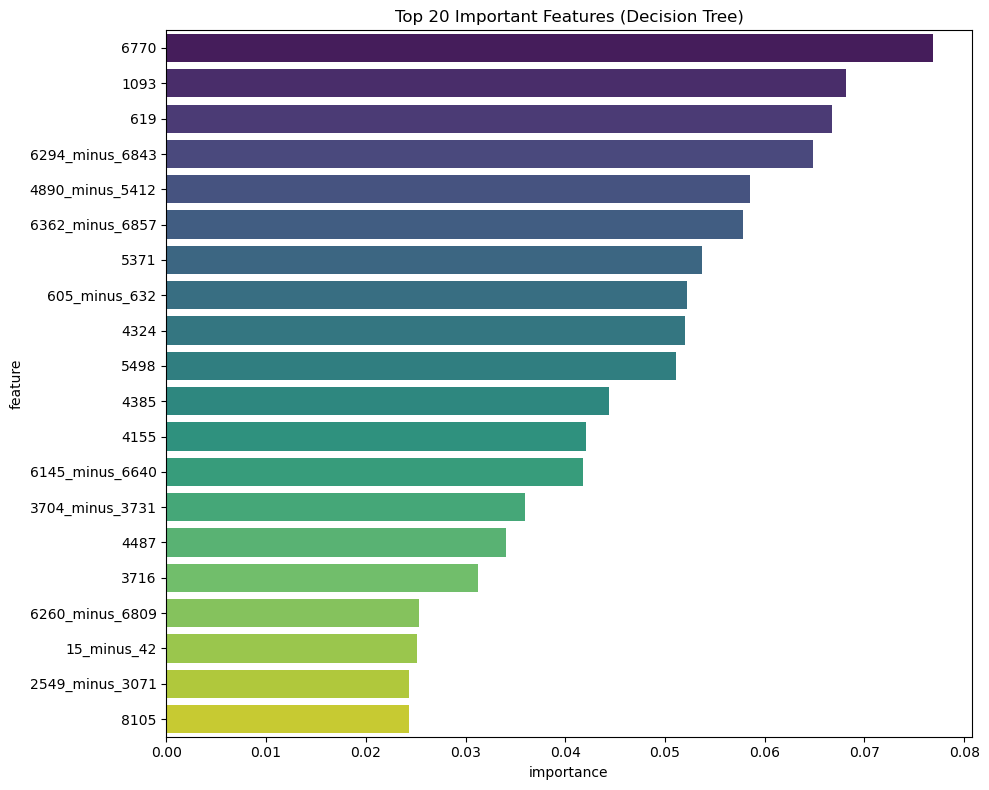

In [12]:
# --- STEP 6: Basic Decision Tree ---

model_basic = DecisionTreeClassifier(random_state=42)
model_basic.fit(X_train_scaled, y_train)
y_pred_basic = model_basic.predict(X_test_scaled)

# --- STEP 6.1: Feature Importance ---

importances = model_basic.feature_importances_
feat_names = X_train.columns if isinstance(X_train, pd.DataFrame) else X.columns

feat_importance_df = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Important Features (Decision Tree)')
plt.tight_layout()
plt.show()

In [13]:
# --- STEP 7: Pruned Tree ---

model_pruned = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
model_pruned.fit(X_train_scaled, y_train)
y_pred_pruned = model_pruned.predict(X_test_scaled)

# --- STEP 7.1: RandomizedSearchCV ---

param_dist = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                            param_distributions=param_dist,
                            n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

# --- (Optional) Save best model ---
joblib.dump(best_model, 'best_dog_cat_model.pkl')


['best_dog_cat_model.pkl']

In [14]:
# --- STEP 8: Model Evaluation ---

print("--- Basic Model ---")
print("Accuracy:", accuracy_score(y_test, y_pred_basic))
print("Classification Report (Dog vs Cat):")
print(classification_report(y_test, y_pred_basic))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_basic))

print("--- Pruned Tree Model ---")
print("Accuracy:", accuracy_score(y_test, y_pred_pruned))
print("Classification Report (Dog vs Cat):")
print(classification_report(y_test, y_pred_pruned))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pruned))

print("--- Best Model from RandomizedSearchCV ---")
print("Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report (Dog vs Cat):")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\n--- Accuracy Comparison ---")
print(f"Basic:      {accuracy_score(y_test, y_pred_basic):.4f}")
print(f"Pruned:     {accuracy_score(y_test, y_pred_pruned):.4f}")
print(f"Optimized:  {accuracy_score(y_test, y_pred_best):.4f}")


--- Basic Model ---
Accuracy: 0.4939759036144578
Classification Report (Dog vs Cat):
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        52
           1       0.32      0.32      0.32        31

    accuracy                           0.49        83
   macro avg       0.46      0.46      0.46        83
weighted avg       0.49      0.49      0.49        83

Confusion Matrix:
[[31 21]
 [21 10]]
--- Pruned Tree Model ---
Accuracy: 0.6144578313253012
Classification Report (Dog vs Cat):
              precision    recall  f1-score   support

           0       0.64      0.87      0.74        52
           1       0.46      0.19      0.27        31

    accuracy                           0.61        83
   macro avg       0.55      0.53      0.51        83
weighted avg       0.58      0.61      0.56        83

Confusion Matrix:
[[45  7]
 [25  6]]
--- Best Model from RandomizedSearchCV ---
Best Params: {'min_samples_split': 5, 'min_samples_le

C:\Users\PC OANH\AppData\Local\Temp\ipykernel_20220\3696580973.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette='Set2')


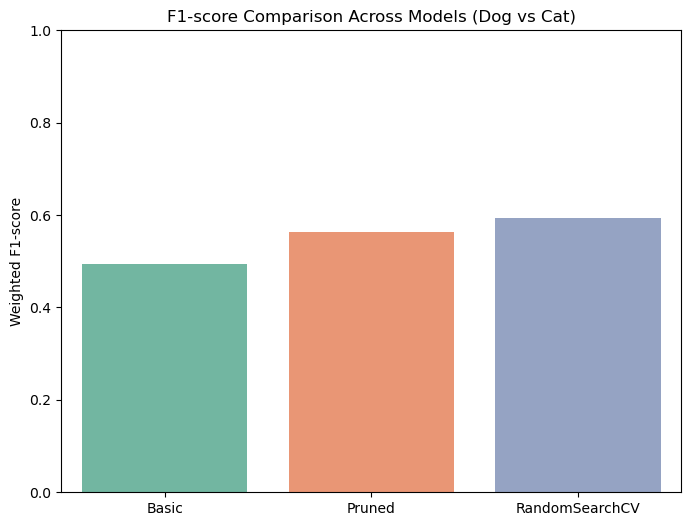

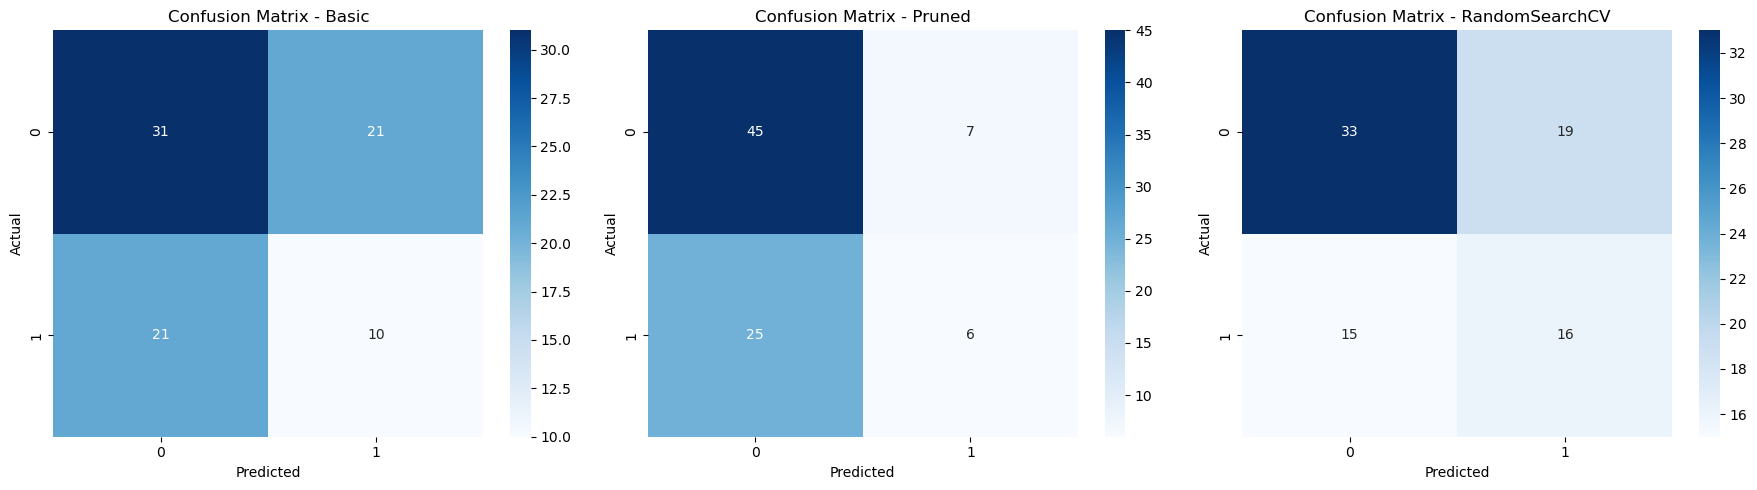

In [15]:
# --- STEP 9: Visualization ---

f1_scores = [
    f1_score(y_test, y_pred_basic, average='weighted'),
    f1_score(y_test, y_pred_pruned, average='weighted'),
    f1_score(y_test, y_pred_best, average='weighted')
]

model_names = ['Basic', 'Pruned', 'RandomSearchCV']

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=f1_scores, palette='Set2')
plt.title('F1-score Comparison Across Models (Dog vs Cat)')
plt.ylabel('Weighted F1-score')
plt.ylim(0, 1)
plt.show()

# Confusion matrix plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, y_pred, title in zip(axes, [y_pred_basic, y_pred_pruned, y_pred_best], model_names):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()
